In [34]:
%%bash

cd svms-data

if ! [ -f criteo.train.txt ] ; then
  wget -q -O criteo.tgz \
    https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz
  tar xzvf criteo.tgz
  rm readme.txt
  rm test.txt
  mv train.txt criteo.train.txt
fi

In [26]:
%%bash
cd svms-data

# # https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#avazu
# avazu is a similar "dense categorical" dataset

# note some large floats can cause VW to throw due to feature
# normalization, so we log-transform them, but we first check
# the minimum offset
head -7465 criteo.train.txt | tail -1 | cut -d$'\t' -f6

1618112


In [10]:
logspace = """
BEGIN { FS = "\t" } ;
{
  for (i = 2; i <= 14 && i <= NF; ++i) {
    if ($i != "" && mins[i] > $i)
      mins[i] = $i
  }
}
END {
    for (i in mins) if (mins[i]) print i ": " mins[i]
}
"""

In [11]:
%%bash -s '{logspace}'

cd svms-data

cat criteo.train.txt | awk "$1"

3: -3


In [12]:
count_three = """
BEGIN { FS = "\t" } ;
{
  if ($3 != "" && $3 <= 0)
      c[$3] += 1
}
END {
    for (i in c) if (c[i]) print i ": " c[i]
}
"""

In [13]:
%%bash -s '{count_three}'

cd svms-data

cat criteo.train.txt | awk "$1"

-1: 4715368
-3: 18
-2: 30510
0: 7969829


In [2]:
# could do log(max($i, 0) + 1) instead of special offset
# for feature 2, but whatever.
logscale = """
BEGIN { FS = "\t"; OFS = "\t" } ;
{
  for (i = 2; i <= 14 && i <= NF; ++i) {
    offset = (i == 3) ? 4 : 1;
    if ($i != "" && $i != 0) $i = log(offset + $i)
    else $i = "0"
  }
  print
}
"""
# keep hash categorical features the same
svmify = """
BEGIN { FS = "\t"; OFS = " " } ;
{
  for (i = 2; i <= 14 && i <= NF; ++i) {
    j = i - 2;
    if ($i != 0) $i = j ":" $i
    else $i = ""
  }
  print
}
"""

In [5]:
%%bash -s '{logscale}' '{svmify}' 

# per https://arxiv.org/abs/1904.13389
# just use labelled training data for train/val for eval
# note that the data is chronologically ordered so there's only one valid split

cd svms-data

head -40000000 criteo.train.txt | awk "$1" > criteo.train.tsv
head -40000000 criteo.train.txt | \
  awk "$1" | awk "$2" > criteo.train.svm
tail -n +40000000 criteo.train.txt | awk "$1" > criteo.test.tsv
tail -n +40000000 criteo.train.txt | \
  awk "$1" | awk "$2" > criteo.test.svm


In [6]:
%%bash

cd svms-data

wc -l criteo.{train,test}.{tsv,svm}

wc -w criteo.{train,test}.{tsv,svm}

   40000000 criteo.train.tsv
   40000000 criteo.train.svm
    5840618 criteo.test.tsv
    5840618 criteo.test.svm
   91681236 total
 1486106054 criteo.train.tsv
 1314348123 criteo.train.svm
  216974696 criteo.test.tsv
  192019158 criteo.test.svm
 3209448031 total


In [7]:
%%bash

echo 'tsv check'
cat svms-data/criteo.train.tsv | \
  cut -d$'\t' -f1 | \
  awk 'BEGIN { FS = "\t" } { cnts[$1] += 1 } END { for (v in cnts) print cnts[v], v }'
  
echo 'svm check'
cat svms-data/criteo.train.svm | \
  cut -d" " -f1 | \
  awk '{ cnts[$1] += 1 } END { for (v in cnts) print cnts[v], v }'

tsv check
29779135 0
10220865 1
svm check
29779135 0
10220865 1


In [ ]:
%%bash

if [ -f svms-data/criteo-results.jsonl ]; then
  echo 'moving existing svms-data/criteo-results.jsonl to /tmp'
  mv svms-data/criteo-results.jsonl /tmp
fi
  
dataset=criteo
for compression_short in \
  "SubmodularSort ss" \
  "NoSplitSubmodularSort ns" \
  "FrequencyTruncation ft" \
  "SubmodularExpansion sm"; do
for budget in $(seq 100 100 1000) ; do 

compression=$(echo $compression_short | cut -d" " -f1)
shortname=$(echo $compression_short | cut -d" " -f2)

RAYON_NUM_THREADS=64 ./csl/target/release/csl \
--budget $budget --compress $compression \
--train ./svms-data/${dataset}.train.tsv \
--valid ./svms-data/${dataset}.test.tsv \
--tsv-dense $(seq 0 12) > ./svms-data/${dataset}.${compression}${i}.log
    
dataset=criteo
quiet="yes"
l1=0
passes=1
neurons=8
delete="yes"
echo $budget $dataset $shortname $quiet $delete

done
done | xargs -P 16 -L1 /bin/bash vw.sh > svms-data/criteo-results.jsonl

In [4]:
import pandas as pd
import json

records = []
with open('svms-data/criteo-results.jsonl', 'r') as f:
    for line in f:
        records.append(json.loads(line))

df = pd.DataFrame.from_records(records)
df.head()

,learner,budget,train_examples,test_examples,dataset,compress,train_sec,train_acc,test_acc,train_logloss,test_logloss
0,vw,100,19999718,5840618,criteo,ss,82.56,0.773485,0.768174,0.483361,0.490754
1,vw,200,19999718,5840618,criteo,ss,90.69,0.777304,0.771906,0.475722,0.483516
2,vw,300,19999718,5840618,criteo,ss,91.22,0.778812,0.773635,0.473321,0.480925
3,vw,400,19999718,5840618,criteo,ss,82.95,0.779534,0.774366,0.471501,0.479154
4,vw,500,19999718,5840618,criteo,ss,83.80,0.780022,0.775060,0.469866,0.477492


In [5]:
df['compress_named'] = df.compress.map({
    'ss': 'Google (Split)', 'sm': 'Ours (Split)', 'ht': 'Hashing Trick',
    'ns': 'Google (No Split)', 'sn': 'Ours (No Split)', 'ft': 'Frequency Truncation'})
df_traintest = df.copy(deep=True)
df_traintest.drop(columns=['test_logloss'], inplace=True)
df_traintest.loc[:, 'tt'] = 'train'
df_traintest.rename(columns={'train_logloss': 'log loss'}, inplace=True)
x = df.copy()
x.drop(columns=['train_logloss'], inplace=True)
x.rename(columns={'test_logloss': 'log loss'}, inplace=True)
x.loc[:, 'tt'] = 'test'
df_tt = pd.concat([df_traintest, x], sort=False)
df_tt.compress_named = df_tt.compress_named.map({
    'Google (Split)': 'split',
    'Google (No Split)': 'no split'
})

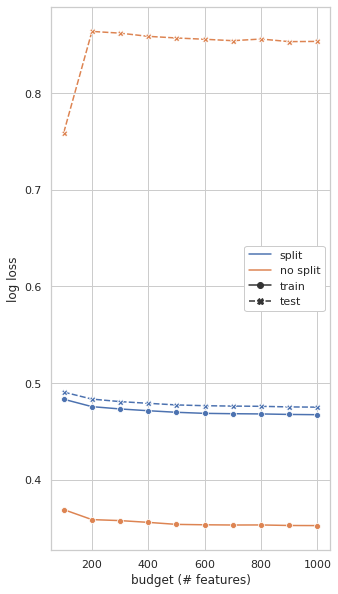

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

df_tt['budget (# features)'] = df_tt.budget
plt.figure(figsize=(5,10))

sns.lineplot(x='budget (# features)', y='log loss', hue='compress_named', style='tt',
                  markers=True, data=df_tt[~pd.isnull(df_tt.compress_named)],
                  legend = 'brief')
handles, labels = plt.gca().get_legend_handles_labels()
handles.pop(3); handles.pop(0)
labels.pop(3); labels.pop(0)
plt.gca().legend(handles=handles, labels=labels, framealpha=1)
#plt.title('Criteo effect of splitting')
plt.savefig('pics/criteo-split.pdf', bbox_inches='tight')
plt.show()

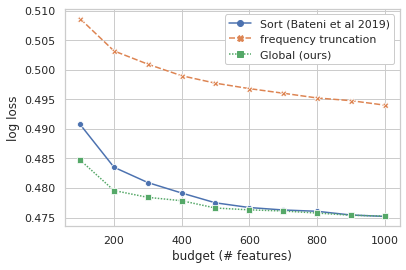

In [49]:
tdf = df.copy()
tdf['compress_named'] = tdf.compress.map({
    'ss': 'Sort (Bateni et al 2019)', 'sm': 'Global (ours)', 'ht': 'hashing trick', 'ft': 'frequency truncation'})
tdf.dropna(inplace=True)
tdf.rename(columns={'test_logloss': 'log loss'}, inplace=True)
tdf['budget (# features)'] = tdf.budget
sns.lineplot(x='budget (# features)', y='log loss', hue='compress_named',
                  markers=True, data=tdf, style='compress_named',
                  legend = 'brief')
  
handles, labels = plt.gca().get_legend_handles_labels()
handles.pop(0)
labels.pop(0)
plt.gca().legend(handles=handles, labels=labels, framealpha=1)

#plt.title('Criteo test log loss vs budge across strategies')
plt.savefig('pics/criteo-compare-submod.pdf', bbox_inches='tight')
plt.show()